In [388]:
import os
import sys
import urllib.request
import json 
import datetime 
import pandas as pd 
from bs4 import BeautifulSoup
from urllib.request import urlopen 
from glob import glob
import operator
import seaborn as sns

#!pip install xlsxwriter

client_id = "u1IEUf8fHCPaCpVyZGgt"
client_secret = "dL13QH3nc5"

import platform
import matplotlib.pyplot as plt 
from matplotlib import font_manager, rc

rc("font", family="Arial Unicode MS")
plt.rcParams["axes.unicode_minus"] = False 

# 문제1) 출판 도서 정보 수집

### 1) 도서 정보 수집을 위한 함수 만들기 
- url = gen_search_url(api_node, search_text, start_num, disp_num)
- get_result_onpage(url)


In [389]:
def gen_search_url(api_node, search_text, start_num, disp_num):
    base = "https://openapi.naver.com/v1/search"
    node = "/" + api_node + ".json"
    param_query = "?query=" + urllib.parse.quote(search_text)
    param_start = "&start=" + str(start_num)
    param_disp = "&display=" + str(disp_num)

    return base + node + param_query + param_start + param_disp 

In [390]:
url = gen_search_url('book', 'c++', 1, 100)

In [391]:
# get_result_onpage

def get_result_onpage(url):
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    response = urllib.request.urlopen(request)
    print("[%s] Url Request Success" % datetime.datetime.now())
    return json.loads(response.read().decode("utf-8"))


In [392]:
data_json = get_result_onpage(url)

[2021-10-20 20:13:25.680429] Url Request Success


### 2) 정리할 항목을 바탕으로 데이터 프레임으로 만들어주는 함수 만들기

<항목>
- isbn (id 역할을 하는 항목)
- title
- author
- price
- publisher
- link (추가과제 책 페이지수를 참고하기 위해서)

<함수>
- get_fields(one_result) 
- delete_tag 

In [393]:
# delete_tag

def delete_tag(input_str):
    input_str = input_str.replace("<b>", "")
    input_str = input_str.replace("</b>", "")
    return input_str 

In [394]:
# get_fields

def get_fields(json_data):
    isbn = [each["isbn"] for each in json_data["items"]]
    title = [delete_tag(each["title"]) for each in json_data["items"]]
    author = [delete_tag(each["author"]) for each in json_data["items"]]
    price = [each["price"] for each in json_data["items"]]
    publisher = [delete_tag(each["publisher"]) for each in json_data["items"]]
    pubdate = [each["pubdate"] for each in json_data["items"]]
    link = [each["link"] for each in json_data["items"]]
    
    result_pd = pd.DataFrame({
        "isbn": isbn, 
        "title": title, 
        "author": author, 
        "price": price,
        "publisher": publisher,
        "pubdate": pubdate,
        "link": link
    }, columns=["isbn", "title", "author", "price", "publisher", "pubdate", "link"])
    return result_pd

In [395]:
result = get_fields(data_json)
result

,isbn,title,author,price,publisher,pubdate,link
0,8970509437 9788970509433,명품 C++ Programming,황기태,30000,생능출판사,20180305,http://book.naver.com/bookdb/book_detail.php?b...
1,8996094048 9788996094043,윤성우 열혈 C++ 프로그래밍,윤성우,27000,오렌지미디어,20100512,http://book.naver.com/bookdb/book_detail.php?b...
2,1165213796 9791165213794,코딩 테스트를 위한 자료 구조와 알고리즘 with C++ (67개 문제 풀이로 익히자!),존 캐리|셰리안 도시|파야스 라잔,32000,길벗,20201208,http://book.naver.com/bookdb/book_detail.php?b...
3,8966263208 9788966263202,266가지 문제로 정복하는 코딩 인터뷰 in C++,아드난 아지즈|쭝시엔 리|아미트 프라카시,35000,인사이트,20211001,http://book.naver.com/bookdb/book_detail.php?b...
4,1158392583 9791158392581,두들낙서의 C/C++ 한꺼번에 배우기 (최고의 명강의를 한 권에 담은),최지훈,27000,위키북스,20210604,http://book.naver.com/bookdb/book_detail.php?b...
...,...,...,...,...,...,...,...
95,1801875448 9781801875448,C++ For Beginners (A Step-by-Step Guide to Lea...,Julian James McKinnon,42730,DuccioManfredi,20210310,http://book.naver.com/bookdb/book_detail.php?b...
96,8945072209 9788945072207,C++ Primer,Stanley B. Lippman|Josee Lajoie|Barbara E. Moo,39000,Pearson,20130530,http://book.naver.com/bookdb/book_detail.php?b...
97,1802260285 9781802260281,C++ FOR BEGINNERS (The Ultimate Guide To Learn...,Tom Clark,35610,MikCorpLtd.,20210317,http://book.naver.com/bookdb/book_detail.php?b...
98,1802260609 9781802260601,C++ FOR BEGINNERS (The Ultimate Guide To Learn...,Tom Clark,45580,MikCorpLtd.,20210317,http://book.naver.com/bookdb/book_detail.php?b...


### 3) 실행 함수 및 엑셀로 변환하는 함수 만들기
- actMain(api_node, search_text)
- toExcel(file_name)

In [396]:
def actMain(search_text):

    result_mol = []
    
    for n in range(1, 1000, 100):
        url = gen_search_url('book', search_text, n, 100)
        json_result = get_result_onpage(url)
        pd_result = get_fields(json_result)

        result_mol.append(pd_result)
        
        
    return pd.concat(result_mol)
    # result_mol.reset_index(drop=True, inplace=True)

In [397]:
result_mol = actMain('파이썬')
result_mol

[2021-10-20 20:13:28.440299] Url Request Success
[2021-10-20 20:13:28.952485] Url Request Success
[2021-10-20 20:13:29.366443] Url Request Success
[2021-10-20 20:13:29.688234] Url Request Success
[2021-10-20 20:13:30.083479] Url Request Success
[2021-10-20 20:13:30.491868] Url Request Success
[2021-10-20 20:13:30.909078] Url Request Success
[2021-10-20 20:13:31.403992] Url Request Success
[2021-10-20 20:13:31.831826] Url Request Success
[2021-10-20 20:13:32.348369] Url Request Success


,isbn,title,author,price,publisher,pubdate,link
0,1162243074 9791162243077,이것이 취업을 위한 코딩 테스트다 with 파이썬 (취업과 이직을 결정하는 알고리즘...,나동빈,34000,한빛미디어,20200805,http://book.naver.com/bookdb/book_detail.php?b...
1,1163030910 9791163030911,Do it! 점프 투 파이썬,박응용,18800,이지스퍼블리싱,20190620,http://book.naver.com/bookdb/book_detail.php?b...
2,1162241888 9791162241882,혼자 공부하는 파이썬 (파이썬 최신 버전 반영),윤인성,18000,한빛미디어,20190610,http://book.naver.com/bookdb/book_detail.php?b...
3,1189909170 9791189909178,파이썬 알고리즘 인터뷰 (95가지 알고리즘 문제 풀이로 완성하는 코딩 테스트),박상길,38000,책만,20200715,http://book.naver.com/bookdb/book_detail.php?b...
4,1162243201 9791162243206,"파이썬 증권 데이터 분석 (파이썬 입문, 웹 스크레이핑, 트레이딩 전략, 자동 매매)",김황후,32000,한빛미디어,20200701,http://book.naver.com/bookdb/book_detail.php?b...
...,...,...,...,...,...,...,...
95,1188786350 9791188786350,실전 예제로 살펴보는 PyQt Tutorial,이호준,0,사도출판,20200929,http://book.naver.com/bookdb/book_detail.php?b...
96,1190014505 9791190014502,더 강해지다 Active Defense (실습으로 미리 준비하는 보안 프레임워크),한주성|최도현|김진경|박제현,21000,비제이퍼블릭,20191011,http://book.naver.com/bookdb/book_detail.php?b...
97,8966261264 9788966261260,오픈 소스 소프트웨어 아키텍처 (25개 애플리케이션으로 배우는),에이미 브라운|그레그 윌슨,36000,인사이트,20150511,http://book.naver.com/bookdb/book_detail.php?b...
98,8931459610 9788931459616,"라즈베리 파이, 상상을 현실로 만드는 프로젝트 입문편 + 라즈베리 파이 키트 세트",이준혁,105000,영진닷컴,20181115,http://book.naver.com/bookdb/book_detail.php?b...


In [398]:
def toExcel(file_name):
    writer = pd.ExcelWriter('data_211020/search_'+file_name, engine="xlsxwriter")
    result_mol.to_excel(writer, sheet_name="Sheet1")

    workbook = writer.book 
    worksheet = writer.sheets["Sheet1"]
    worksheet.set_column("A:A", 4)
    worksheet.set_column("B:B", 25)
    worksheet.set_column("C:C", 60)
    worksheet.set_column("D:D", 10)
    worksheet.set_column("E:E", 10)
    worksheet.set_column("F:F", 20)
    worksheet.set_column("G:G", 15)
    worksheet.set_column("H:H", 60)

    worksheet.conditional_format("E2:E1001", {"type": "3_color_scale"})
    writer.save()

### * 10가지 언어에 대한 검색 결과 저장하기 실행

In [399]:
searchWord = ['python', '파이썬', 'C언어', 'java', 'C++', 'C#', 'Visual Basic', 'SQL', 'PHP', 'R프로그래밍', 'R통계']

for word in searchWord:
    result_mol=actMain(word)
    toExcel(word+'.xlsx')
    print(word)


[2021-10-20 20:13:32.848292] Url Request Success
[2021-10-20 20:13:33.353965] Url Request Success
[2021-10-20 20:13:33.759037] Url Request Success
[2021-10-20 20:13:34.273423] Url Request Success
[2021-10-20 20:13:34.794912] Url Request Success
[2021-10-20 20:13:35.299756] Url Request Success
[2021-10-20 20:13:35.808926] Url Request Success
[2021-10-20 20:13:36.324602] Url Request Success
[2021-10-20 20:13:36.833432] Url Request Success
[2021-10-20 20:13:37.231002] Url Request Success
python
[2021-10-20 20:13:37.706500] Url Request Success
[2021-10-20 20:13:38.050374] Url Request Success
[2021-10-20 20:13:38.386482] Url Request Success
[2021-10-20 20:13:38.742649] Url Request Success
[2021-10-20 20:13:39.083704] Url Request Success
[2021-10-20 20:13:39.432063] Url Request Success
[2021-10-20 20:13:40.007922] Url Request Success
[2021-10-20 20:13:40.520203] Url Request Success
[2021-10-20 20:13:40.698371] Url Request Success
[2021-10-20 20:13:41.138866] Url Request Success
파이썬
[2021-10-

# 문제2) 중복되는 데이터 제거

### 1) 데이터 다시 불러와서 한 데이터 프레임에 담기

In [400]:
files=glob("data_211020/search_*.xlsx")
files

['data_211020/search_PHP.xlsx',
 'data_211020/search_SQL.xlsx',
 'data_211020/search_python.xlsx',
 'data_211020/search_java.xlsx',
 'data_211020/search_R통계.xlsx',
 'data_211020/search_C#.xlsx',
 'data_211020/search_Visual Basic.xlsx',
 'data_211020/search_R프로그래밍.xlsx',
 'data_211020/search_파이썬.xlsx',
 'data_211020/search_C++.xlsx',
 'data_211020/search_C언어.xlsx']

In [401]:
tmp_raw = []

for file_name in files:
    tmp = pd.read_excel(file_name, index_col=0)
    tmp_raw.append(tmp)

search_raw = pd.concat(tmp_raw)

In [402]:
search_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10576 entries, 0 to 99
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   isbn       10575 non-null  object 
 1   title      10576 non-null  object 
 2   author     10555 non-null  object 
 3   price      10566 non-null  float64
 4   publisher  10575 non-null  object 
 5   pubdate    10573 non-null  object 
 6   link       10576 non-null  object 
dtypes: float64(1), object(6)
memory usage: 661.0+ KB


### 2) 중복되는 행을 제거하고 고유한 값만 남기기

In [403]:
search_raw.duplicated(['isbn'])

0     False
1     False
2     False
3     False
4     False
      ...  
95    False
96    False
97    False
98    False
99    False
Length: 10576, dtype: bool

In [404]:
search = search_raw.drop_duplicates(['isbn'], keep='first')

In [405]:
search.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10019 entries, 0 to 99
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   isbn       10018 non-null  object 
 1   title      10019 non-null  object 
 2   author     9999 non-null   object 
 3   price      10009 non-null  float64
 4   publisher  10018 non-null  object 
 5   pubdate    10016 non-null  object 
 6   link       10019 non-null  object 
dtypes: float64(1), object(6)
memory usage: 626.2+ KB


In [406]:
search.tail()

,isbn,title,author,price,publisher,pubdate,link
95,3110149133 9783110149135,Language change and functional explanations,Jadranka Gvozdanovi´c,333190.0,MoutondeGruyter,1997,http://book.naver.com/bookdb/book_detail.php?b...
96,0844207993 9780844207995,Lado a Lado Gramatica Inglesa y Espanola / Sid...,C. Farrell,19320.0,McGraw-HillCompanies,19980801,http://book.naver.com/bookdb/book_detail.php?b...
97,1605207241 9781605207247,Red Hot Internet Publicity: An Insider's Guide...,Penny C. Sansevieri,28900.0,Cosimo,20090630,http://book.naver.com/bookdb/book_detail.php?b...
98,0521808634 9780521808637,Introduction to Comets,John C. Brandt and Robert D. Chapman,239741.0,CambridgeUniversityPress,20040301,http://book.naver.com/bookdb/book_detail.php?b...
99,0194013758 9780194013758,Tactics for Listening(Basic)(Teacher s Book)(T...,Jack C. Richards,42000.0,OXFORDUNIVERSITYPRESS,20111201,http://book.naver.com/bookdb/book_detail.php?b...


# 문제 3) 언어별 출판물 양으로 순위 매기기

In [407]:
searchWord

['python',
 '파이썬',
 'C언어',
 'java',
 'C++',
 'C#',
 'Visual Basic',
 'SQL',
 'PHP',
 'R프로그래밍',
 'R통계']

In [408]:
searchWord[4] = 'C\+\+'
searchWord[5] = 'C\#'

In [409]:
# searchWord 리스트 활용해서 cnt 열을 포함한 데이터 프레임 만들기

df = pd.DataFrame(columns=['idx','cnt'])

for i in searchWord : 
    idx=i
    cnt=sum(search['title'].str.contains(i, case=False))
    df = df.append(pd.DataFrame([[idx,cnt]],columns=['idx','cnt']),ignore_index=True)

df

,idx,cnt
0,python,1062
1,파이썬,690
2,C언어,466
3,java,1045
4,C\+\+,1017
5,C\#,975
6,Visual Basic,981
7,SQL,1132
8,PHP,996
9,R프로그래밍,7


In [410]:
# 검색시 중복되었던 항목 제거

df_1=df.copy()
df_1.iloc[0].cnt=(df.iloc[0]+df.iloc[1]).cnt
df_1 = df_1.drop([1])
df_1.iloc[9].cnt=(df.iloc[9]+df.iloc[10]).cnt
df_1 = df_1.drop([10])

In [411]:
df_1.reset_index(drop=True)

,idx,cnt
0,python,1752
1,C언어,466
2,java,1045
3,C\+\+,1017
4,C\#,975
5,Visual Basic,981
6,SQL,1132
7,PHP,996
8,R프로그래밍,7


In [413]:
# rank
df_2 = df_1.copy()
df_2['rank'] = df_2['cnt'].rank(ascending=False)

df_2.sort_values(by='rank', inplace=True)
df_2

,idx,cnt,rank
0,python,1752,1.0
7,SQL,1132,2.0
3,java,1045,3.0
4,C\+\+,1017,4.0
8,PHP,996,5.0
6,Visual Basic,981,6.0
5,C\#,975,7.0
2,C언어,466,8.0
9,R프로그래밍,7,9.0


### +) 시각화하기

<AxesSubplot:xlabel='idx'>

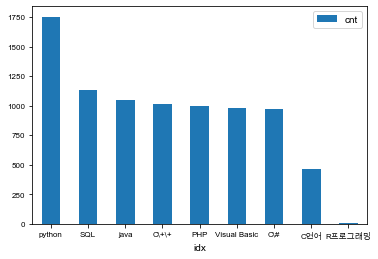

In [414]:
df_2.plot.bar(x='idx', y='cnt', rot=0, fontsize=8)


# 문제 4) 수집된 정보 기반으로 출판사 순위 확인

In [415]:
search.head()

,isbn,title,author,price,publisher,pubdate,link
0,0076561119 4910076561113,PHPスペシャル增刊 2021年11月號 (人生がうまくいく言葉の力),편집부,6500.0,PHP硏究所,20210922.0,http://book.naver.com/bookdb/book_detail.php?b...
1,1156644445 9791156644446,PHP 프로그래밍 입문 (PHP Web Programming),황재호,25000.0,한빛아카데미,20190520.0,http://book.naver.com/bookdb/book_detail.php?b...
2,115839134X 9791158391348,생활코딩! PHP+MySQL,이고잉,27000.0,위키북스,20190115.0,http://book.naver.com/bookdb/book_detail.php?b...
3,4569901646 9784569901640,讀む力を鍛える (PHP文庫),사토 마사루,10610.0,PHP硏究所,20211007.0,http://book.naver.com/bookdb/book_detail.php?b...
4,4569901662 9784569901664,コ-ヒ-と樂しむ 心がほんのり明るくなる50の物語(PHP文庫),니시자와 야스오,10030.0,PHP硏究所,20211007.0,http://book.naver.com/bookdb/book_detail.php?b...


/Users/annmunju/miniforge3/envs/ds_study/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


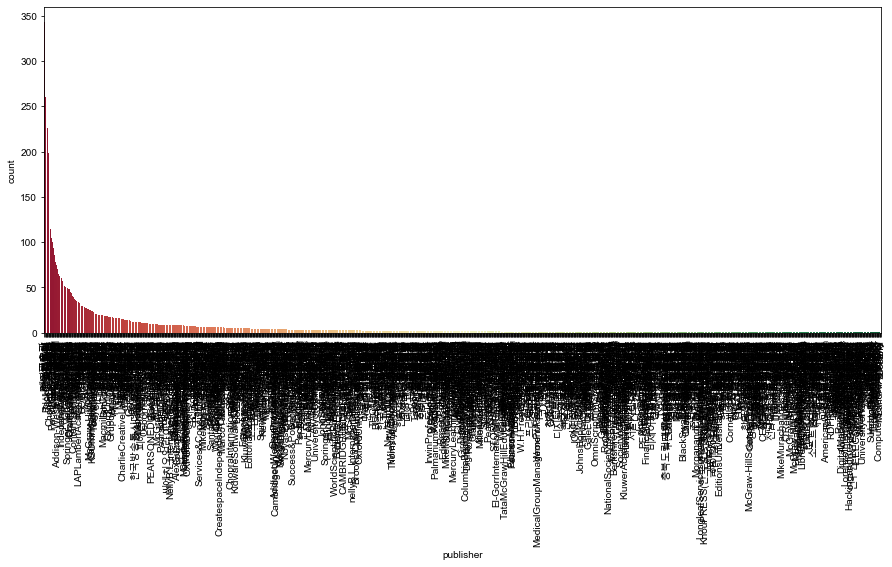

In [420]:
plt.figure(figsize=(15, 6))
sns.countplot(
    search["publisher"], 
    data=search, 
    palette="RdYlGn",
    order=search["publisher"].value_counts().index
)
plt.xticks(rotation=90)
plt.show()

/Users/annmunju/miniforge3/envs/ds_study/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


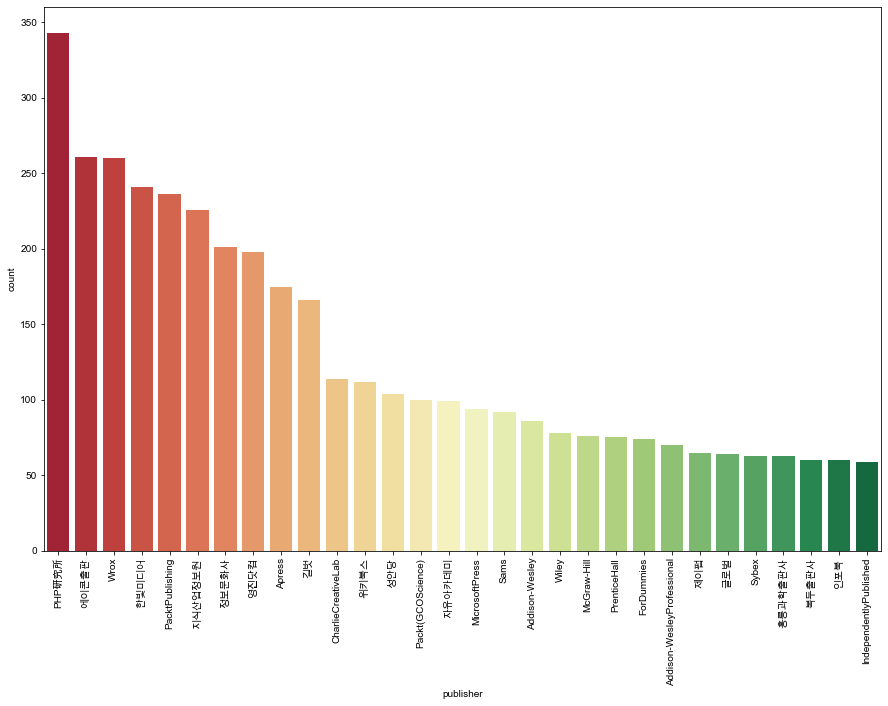

In [421]:
#상위 30개 출판사 보기
plt.figure(figsize=(15, 10))
sns.countplot(
    search["publisher"], 
    data=search, 
    palette="RdYlGn",
    order=search["publisher"].value_counts().iloc[:30].index
)
plt.xticks(rotation=90)
plt.show()

In [422]:
search["publisher"].value_counts().iloc[:30].index

Index(['PHP硏究所', '에이콘출판', 'Wrox', '한빛미디어', 'PacktPublishing', '지식산업정보원',
       '정보문화사', '영진닷컴', 'Apress', '길벗', 'CharlieCreativeLab', '위키북스', '성안당',
       'Packt(GCOScience)', '자유아카데미', 'MicrosoftPress', 'Sams',
       'Addison-Wesley', 'Wiley', 'McGraw-Hill', 'PrenticeHall', 'ForDummies',
       'Addison-WesleyProfessional', '제이펍', '글로벌', 'Sybex', '홍릉과학출판사', '복두출판사',
       '인포북', 'IndependentlyPublished'],
      dtype='object')

# 문제 5) 출판일 기준 최근 2년(20, 21년) / 이전 3년 (17, 18, 19년) 비교

In [464]:
search.head()

,isbn,title,author,price,publisher,pubdate,link
0,0076561119 4910076561113,PHPスペシャル增刊 2021年11月號 (人生がうまくいく言葉の力),편집부,6500.0,PHP硏究所,20210922.0,http://book.naver.com/bookdb/book_detail.php?b...
1,1156644445 9791156644446,PHP 프로그래밍 입문 (PHP Web Programming),황재호,25000.0,한빛아카데미,20190520.0,http://book.naver.com/bookdb/book_detail.php?b...
2,115839134X 9791158391348,생활코딩! PHP+MySQL,이고잉,27000.0,위키북스,20190115.0,http://book.naver.com/bookdb/book_detail.php?b...
3,4569901646 9784569901640,讀む力を鍛える (PHP文庫),사토 마사루,10610.0,PHP硏究所,20211007.0,http://book.naver.com/bookdb/book_detail.php?b...
4,4569901662 9784569901664,コ-ヒ-と樂しむ 心がほんのり明るくなる50の物語(PHP文庫),니시자와 야스오,10030.0,PHP硏究所,20211007.0,http://book.naver.com/bookdb/book_detail.php?b...


In [465]:
df=search.astype({'pubdate':'str'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10019 entries, 0 to 99
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   isbn       10018 non-null  object 
 1   title      10019 non-null  object 
 2   author     9999 non-null   object 
 3   price      10009 non-null  float64
 4   publisher  10018 non-null  object 
 5   pubdate    10019 non-null  object 
 6   link       10019 non-null  object 
dtypes: float64(1), object(6)
memory usage: 884.2+ KB


### 1) 출판일 기준 최근 / 이전 데이터 프레임 만들기
- 최근 : search_recent
- 이전 : search_before

In [468]:
df_1=df[df['pubdate'].str.contains("2021")]
df_2=df[df['pubdate'].str.contains("2020")]
search_recent = pd.concat([df_1,df_2])

In [473]:
search_recent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2537 entries, 0 to 48
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   isbn       2537 non-null   object 
 1   title      2537 non-null   object 
 2   author     2537 non-null   object 
 3   price      2537 non-null   float64
 4   publisher  2537 non-null   object 
 5   pubdate    2537 non-null   object 
 6   link       2537 non-null   object 
dtypes: float64(1), object(6)
memory usage: 158.6+ KB


In [474]:
df_1=df[df['pubdate'].str.contains("2019")]
df_2=df[df['pubdate'].str.contains("2018")]
df_3=df[df['pubdate'].str.contains("2017")]
search_before = pd.concat([df_1,df_2,df_3])

In [475]:
search_before.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1826 entries, 1 to 85
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   isbn       1826 non-null   object 
 1   title      1826 non-null   object 
 2   author     1825 non-null   object 
 3   price      1826 non-null   float64
 4   publisher  1826 non-null   object 
 5   pubdate    1826 non-null   object 
 6   link       1826 non-null   object 
dtypes: float64(1), object(6)
memory usage: 114.1+ KB


### 2-1) 두 기간의 데이터 : 언어별 count 순위 파악

In [479]:
# 최근 데이터 (search_recent)

df = pd.DataFrame(columns=['idx','cnt'])

for i in searchWord : 
    idx=i
    cnt=sum(search_recent['title'].str.contains(i, case=False))
    df = df.append(pd.DataFrame([[idx,cnt]],columns=['idx','cnt']),ignore_index=True)

# 검색시 중복되었던 항목 제거

df_1=df.copy()
df_1.iloc[0].cnt=(df.iloc[0]+df.iloc[1]).cnt
df_1 = df_1.drop([1])
df_1.iloc[9].cnt=(df.iloc[9]+df.iloc[10]).cnt
df_1 = df_1.drop([10])

df_1.reset_index(drop=True)

# rank
df_2 = df_1.copy()
df_2['rank'] = df_2['cnt'].rank(ascending=False)

df_2.sort_values(by='rank', inplace=True)
df_2

,idx,cnt,rank
0,python,1253,1.0
3,java,285,2.0
7,SQL,222,3.0
8,PHP,143,4.0
4,C\+\+,135,5.0
5,C\#,93,6.0
2,C언어,24,7.0
6,Visual Basic,20,8.0
9,R프로그래밍,1,9.0


In [480]:
# 과거 데이터 (search_before)

df = pd.DataFrame(columns=['idx','cnt'])

for i in searchWord : 
    idx=i
    cnt=sum(search_before['title'].str.contains(i, case=False))
    df = df.append(pd.DataFrame([[idx,cnt]],columns=['idx','cnt']),ignore_index=True)

# 검색시 중복되었던 항목 제거

df_1=df.copy()
df_1.iloc[0].cnt=(df.iloc[0]+df.iloc[1]).cnt
df_1 = df_1.drop([1])
df_1.iloc[9].cnt=(df.iloc[9]+df.iloc[10]).cnt
df_1 = df_1.drop([10])

df_1.reset_index(drop=True)

# rank
df_2 = df_1.copy()
df_2['rank'] = df_2['cnt'].rank(ascending=False)

df_2.sort_values(by='rank', inplace=True)
df_2

,idx,cnt,rank
0,python,365,1.0
3,java,289,2.0
7,SQL,186,3.0
8,PHP,159,4.0
4,C\+\+,146,5.0
5,C\#,119,6.0
2,C언어,40,7.5
6,Visual Basic,40,7.5
9,R프로그래밍,3,9.0
